# QC

This is a notebook for implementing SNAP's Quality Control on the data products produced in this pipeline.

In [30]:
import os
import re
import rasterio
import threading
import concurrent.futures
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path

base_dir = "/atlas_scratch/ALFRESCO/Runs/2022/SERDP_Fish_and_Fire"
subpaths = ['vegetation/mode', 'vegetation/percent', 'flammability']

historical_fire_dir = base_dir + "/input/HistoricalFires"

combos = [
    'GFDL-CM3_RCP85_NoFMO',
    'GFDL-CM3_RCP85_FMO',
    'GFDL-CM3_RCP85_AltFMO',
    'NCAR-CCSM4_RCP85_NoFMO',
    'NCAR-CCSM4_RCP85_FMO',
    'NCAR-CCSM4_RCP85_AltFMO',
]

## Metadata and tag checks

First, set up the function to read metadata from all GeoTIFFs in parallel:

In [31]:
def meta_and_tag_check(directory):
    all_meta = []
    all_tags = []
    fps = [x for x in directory.glob("*.tif")]
    read_lock = threading.Lock()

    def process(fp):
        src = rasterio.open(fp)
        with read_lock:
            profile = src.profile
            tags = src.tags()
            all_meta.append(profile)
            all_tags.append(tags)
    
    # We map the process() function over the list of files
    with concurrent.futures.ThreadPoolExecutor(
        max_workers=32
    ) as executor:
        executor.map(process, fps)

    return {
        "meta": all_meta,
        "tags": all_tags
    }

Run the metadata extraction for all GeoTIFF types (vegetation mode, vegetation percent, flammability) and all combinations of models and fire management options (FMO) scenarios:

In [32]:
meta = {}
tags = {}
for subpath in subpaths:
    meta[subpath] = []
    tags[subpath] = []
    for combo in combos:
        path = base_dir + "/" + combo + "/post/" + subpath
        combo_dir = Path(path)
        meta_and_tags = meta_and_tag_check(combo_dir)
        meta[subpath] += meta_and_tags["meta"]
        tags[subpath] += meta_and_tags["tags"]

Take a look at the metadata for one GeoTIFF from each type of GeoTIFFs:

In [33]:
for subpath in subpaths:
    print("Metadata for " + subpath + ":")
    print(meta[subpath][0], end="\n\n")

Metadata for vegetation/mode:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 3650, 'height': 2100, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(1000.0, 0.0, -1725223.205807,
       0.0, -1000.0, 2544412.932644), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

Metadata for vegetation/percent:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3650, 'height': 2100, 'count': 9, 'crs': CRS.from_epsg(3338), 'transform': Affine(1000.0, 0.0, -1725223.205807,
       0.0, -1000.0, 2544412.932644), 'tiled': False, 'compress': 'lzw', 'interleave': 'pixel'}

Metadata for flammability:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3650, 'height': 2100, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(1000.0, 0.0, -1725223.205807,
       0.0, -1000.0, 2544412.932644), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}



Observe from the output above that each type of GeoTIFF (vegetation mode, vegetation percent, flammability) has slightly different metadata. Vegetation mode uses the `uint8` data type whereas the others use `float32`. Vegetation percent has 9 bands whereas the others have 1 band. We can verify that all GeoTIFFs in each series has the same metadata as long as we only compare between GeoTIFFs of the same type. Let's do this now:

In [34]:
for subpath in subpaths:
    assert(all([dict(x) == meta[subpath][0] for x in meta[subpath]]) == True)

If the above assertion returns no errors, we have confirmed that all GeoTIFFs share the same metadata with other GeoTIFFs of the same type.

Next, let's take a look at the GeoTIFF tags:

In [35]:
for subpath in subpaths:
    print("Tags for " + subpath + ":")
    print(tags[subpath][0], end="\n\n")

Tags for vegetation/mode:
{'AREA_OR_POINT': 'Area', 'TIFFTAG_IMAGEDESCRIPTION': 'Value Index: 0=NoVeg, 1=Black Spruce, 2=White Spruce, 3=Deciduous, 4=Shrub Tundra, 5=Graminoid Tundra, 6=Wetland Tundra, 7=Barren/Lichen/Moss, 8=Temperate Rainforest', 'TIFFTAG_SOFTWARE': 'ALFRESCO 2.2.1 from UAF.'}

Tags for vegetation/percent:
{'AREA_OR_POINT': 'Area', 'TIFFTAG_IMAGEDESCRIPTION': 'Values represent percentage of vegetation type. Band Index: 1=NoVeg, 2=Black Spruce, 3=White Spruce, 4=Deciduous, 5=Shrub Tundra, 6=Graminoid Tundra, 7=Wetland Tundra, 8=Barren/Lichen/Moss, 9=Temperate Rainforest', 'TIFFTAG_SOFTWARE': 'ALFRESCO 2.2.1 from UAF.'}

Tags for flammability:
{'AREA_OR_POINT': 'Area', 'TIFFTAG_IMAGEDESCRIPTION': 'Values represent flammability.', 'TIFFTAG_SOFTWARE': 'ALFRESCO 2.2.1 from UAF.'}



Observe that the `TIFFTAG_IMAGEDESCRIPTION` and `TIFFTAG_SOFTWARE` tags are being used to communicate import information about these GeoTIFFs, including:

- the version of ALFRESCO that was used to generated the GeoTIFFs
- what the values represent
- the value index for vegetation mode GeoTIFFs
- the band index for vegetation percent GeoTIFFs

Now let's confirm that all GeoTIFFs of similar types share the same tags, similar to what we did for the metadata earlier:

In [36]:
for subpath in subpaths:
    assert(all([dict(x) == tags[subpath][0] for x in tags[subpath]]) == True)

## Declare common data check functions

These functions will be used throughout the rest of the notebook to analyze each type of GeoTIFF (vegetation mode, vegetation percent, flammability).

The `get_geotiff_series` function will be used to get a set of GeoTIFFs corresponding to the provided years. Informaton about the GeoTIFF's year and model & FMO scenario combination are bundled with the file path for use in plot titles. The `get_stat_summary_from_raster_list` function calculates the min, max, and mean of a raster array to be used in some sanity checks.

In [37]:
def get_geotiff_series(combo, subpath, years=['2000', '2050', '2100']):
    path = base_dir + '/' + combo + subpath
    combo_dir = Path(path)
    fps = []
    for year in years:
        for file in combo_dir.glob("*{}*.tif".format(year)):
            fps.append({
                'title': combo,
                'year': year,
                'tif': file
            })
    return fps


def get_stat_summary_from_raster_list(rstrs, band=1, precision=1):
    di = {}
    for rstr_dict in rstrs:
        fp = rstr_dict["tif"]
        fp_key = fp.name[:-4] + " Band " + str(band)
        di[fp_key] = {}
        with rasterio.open(fp) as src:
            arr = src.read(band).astype(float)
            arr[arr == src.nodata] = np.nan
            di[fp_key]["arr"] = arr
            di[fp_key]["min"] = np.round(np.nanmin(arr), precision)
            di[fp_key]["max"] = np.round(np.nanmax(arr), precision)
            di[fp_key]["mean"] = np.round(np.nanmean(arr), precision)
    return di

## Vegetation mode data checks

In [38]:
mode_sample = []
for combo in combos:
    mode_sample += get_geotiff_series(combo, "/post/vegetation/mode")

In [39]:
mode_sample_di = get_stat_summary_from_raster_list(mode_sample)
mode_sample_di

{'Mode_Vegetation_2000 Band 1': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ...,  8.,  8.,  8.],
         [nan, nan, nan, ...,  8.,  8.,  8.],
         [nan, nan, nan, ...,  8.,  8.,  8.]]),
  'min': 0.0,
  'max': 8.0,
  'mean': 2.5},
 'Mode_Vegetation_2050 Band 1': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ...,  8.,  8.,  8.],
         [nan, nan, nan, ...,  8.,  8.,  8.],
         [nan, nan, nan, ...,  8.,  8.,  8.]]),
  'min': 0.0,
  'max': 8.0,
  'mean': 2.9},
 'Mode_Vegetation_2100 Band 1': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ...,  8.,  8.,  8.],
         [nan, n

Possible values for the vegetation mode GeoTIFFs are 0-8, with a nodata value of 255. The data skews heavily towards the 0-4 range, however, so we should expect the mean to be below 5. Let's check this.

In [40]:
for k in mode_sample_di.keys():
    assert(mode_sample_di[k]["min"] == 0)
    assert(mode_sample_di[k]["max"] == 8)
    assert(mode_sample_di[k]["mean"] < 5)

If the assertions above returned no error, the data passed the first check! Next, let's define a function that converts a Rasterio color map into a Matplotlib-compatible color map so the vegetation mode plots in this notebook use the same color map that is encoded into the GeoTIFFs.

In [41]:
def convert_colormap(rasterio_cmap):
    matplotlib_cmap = []
    cmap_values = list(rasterio_cmap.values())
    for values in cmap_values:
        # Convert integers to decimal color representations
        value_list = map(lambda x: x / 255, list(values))
        matplotlib_cmap.append(list(value_list))
    return ListedColormap(matplotlib_cmap[0:8])

Now let's plot each vegetation mode GeoTIFF from our sample. These include GeoTIFFs from each combination of model and FMO scenario for the years 1901, 2000, and 2100.

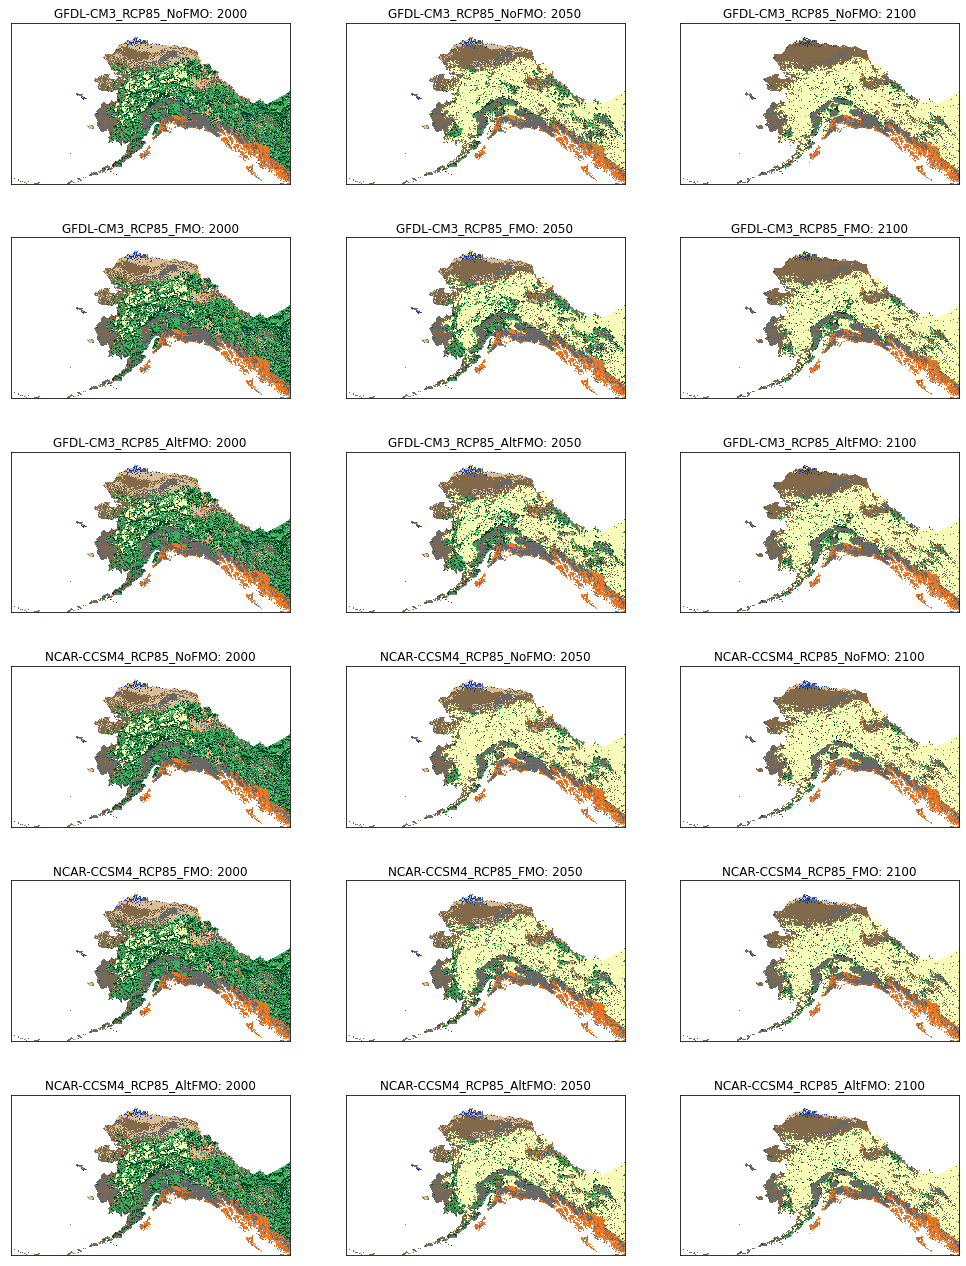

In [42]:
fig, axs = plt.subplots(6, 3, figsize=(17, 23), sharex=True, sharey=True)
fig.patch.set_facecolor("white")
for ax, fp in zip(axs.flatten(), mode_sample):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    with rasterio.open(fp["tif"]) as src:
        arr = src.read(1).astype(float)
        arr[arr == src.nodata] = np.nan
        cmap = convert_colormap(src.colormap(1))
        ax.imshow(arr, cmap=cmap, interpolation="none")
        ax.set_title(fp["title"] + ": " + fp["year"])

The plots from each column (year) look very similar to each other, don't they? What should we expect to see? The plots for the year 2000 are in fact identical because until the year 2015 all ALFRESCO runs are using the same CRU TS 4.0 climate data and historical fire data. The variations between models and FMO scenarios do not kick in until after 2015.

After 2015, you can see quite a bit of variation between the models in the interior (2050) and northern coast (2100). There is also some variation between FMO scenarios, but you have to look very closely to see it. The very slight variation in FMO scenarios aligns with what we have been told by previous ALFRESCO developers.

To verify that the splotches of deciduous forest (yellow) in the 2000 column correspond to historical fires, let's take a look at a few historical fire input GeoTIFFs vs. vegetation mode GeoTIFFs for the subsequent years.

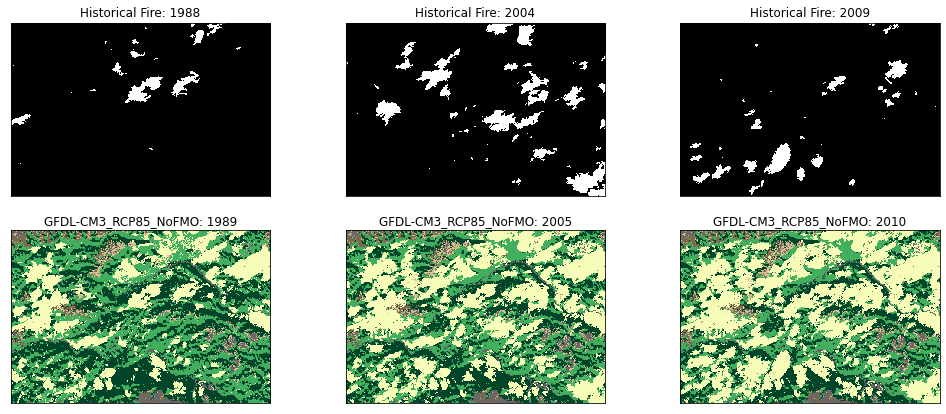

In [43]:
fig, axs = plt.subplots(2, 3, figsize=(17, 7), sharex=True, sharey=True)
fig.patch.set_facecolor("white")
historical_fire_dir = base_dir + "/input/HistoricalFires"

historical_fires = []
historical_fire_years = ['1988', '2004', '2009']
for year in historical_fire_years:   
    historical_fires.append({
        "tif": historical_fire_dir + "/AlaskaFireHistory_{}.tif".format(year),
        "year": year,
        "title": "Historical Fire"
    })

veg_mode_years = map(lambda x: str(int(x) + 1), historical_fire_years)
fire_scars = get_geotiff_series(combos[0], '/post/vegetation/mode', veg_mode_years)

comparisons = historical_fires + fire_scars

for ax, fp in zip(axs.flatten(), comparisons):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    with rasterio.open(fp["tif"]) as src:
        arr = src.read(1).astype(float)
        arr[arr == src.nodata] = np.nan

        try:
            cmap = convert_colormap(src.colormap(1))
        except:
            cmap = "binary_r"

        ax.imshow(arr[600:1000, 1700:2300], cmap=cmap, interpolation="none")
        ax.set_title(fp["title"] + ": " + fp["year"])

Observe that the shapes of the historical fires show up as splotches of deciduous forest the next year.

## Vegetation percent data checks

Since the vegetation percent GeoTIFFs have 9 bands, let's look at all 9 bands of just one GeoTIFF.

In [44]:
percent_sample = []
for combo in combos:
    percent_sample += get_geotiff_series(combo, "/post/vegetation/percent", ['2100'])

In [45]:
percent_sample_dis = []
for band in range(1, 10):
    percent_sample_dis.append(get_stat_summary_from_raster_list(percent_sample, band))
percent_sample_dis

[{'Percent_Vegetation_2100 Band 1': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ...,  0.,  0.,  0.],
          [nan, nan, nan, ...,  0.,  0.,  0.],
          [nan, nan, nan, ...,  0.,  0.,  0.]]),
   'min': 0.0,
   'max': 100.0,
   'mean': 17.4}},
 {'Percent_Vegetation_2100 Band 2': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ...,  0.,  0.,  0.],
          [nan, nan, nan, ...,  0.,  0.,  0.],
          [nan, nan, nan, ...,  0.,  0.,  0.]]),
   'min': 0.0,
   'max': 100.0,
   'mean': 6.1}},
 {'Percent_Vegetation_2100 Band 3': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, n

Possible values for the vegetation percent GeoTIFFs are 0.0-100.0, with a nodata value of -9999. Generally we shouldn't expect the mean value for any vegetation precent GeoTIFF band to exceed ~70%, but this is more of a rule of thumb. Let's check it anyway because any mean higher than 70% should catch our attention.

In [1]:
for percent_sample_di in percent_sample_dis:
    for k in percent_sample_di.keys():
        assert(percent_sample_di[k]["min"] == 0.0)
        assert(percent_sample_di[k]["max"] == 100.0)
        assert(percent_sample_di[k]["mean"] < 70.0)

NameError: name 'percent_sample_dis' is not defined

Next, let's plot each band from a single vegetation percent GeoTIFF.

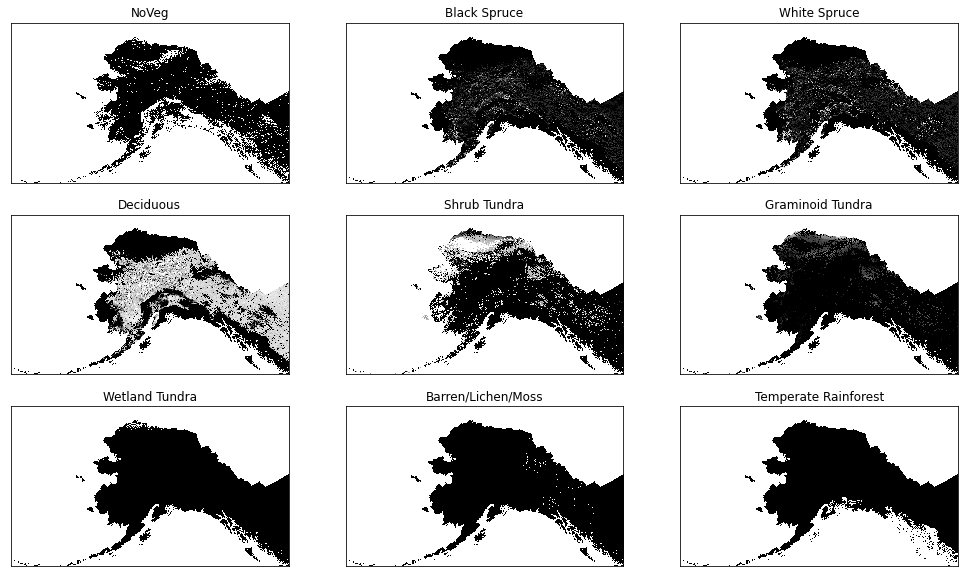

In [47]:
fig, axs = plt.subplots(3, 3, figsize=(17, 10), sharex=True, sharey=True)
fig.patch.set_facecolor("white")
last_year = percent_sample[-1]
bands = range(1, 10)
for ax, band in zip(axs.flatten(), bands):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    with rasterio.open(last_year["tif"]) as src:
        description = src.tags()["TIFFTAG_IMAGEDESCRIPTION"]
        matches = re.findall(r"([0-9]+)\=([\w/ ]+)", description)
        veg_bands = dict(matches)
        veg_bands = {int(k):v for k, v in veg_bands.items()}
        arr = src.read(band).astype(float)
        arr[arr == src.nodata] = np.nan
        ax.imshow(arr, cmap="gray", interpolation="none")
        ax.set_title(veg_bands[band])

Any pixel that shows as bright white in one plot should show as black in the others. Dark gray values can be evenly distributed between several plots. This all appears to be the case, so this passes the eyeball test. Also note how the title of each plot was taken from the band index of the `TIFFTAG_IMAGEDESCRIPTION` GeoTIFF tag, which means that tag is working as designed too!

## Flammability data checks

In [48]:
flammability_sample = []
flammability_years = ['1940', '2004', '2025']
for combo in combos:
    flammability_sample += get_geotiff_series(combo, "/post/flammability", flammability_years)

In [49]:
flammability_sample_di = get_stat_summary_from_raster_list(flammability_sample, 1, 5)
flammability_sample_di

{'Flammability_1940 Band 1': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.]]),
  'min': 0.0,
  'max': 0.21,
  'mean': 0.00682},
 'Flammability_2004 Band 1': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.]]),
  'min': 0.0,
  'max': 1.0,
  'mean': 0.01063},
 'Flammability_2025 Band 1': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, n

Possible values for the flammability GeoTIFFs are 0.0 - 1.0, with a nodata value of -9999. The value for each pixel represents the number of times that pixel showed as an active fire across all 200 ALFRESCO replicates.

We would normally expect values to be much closer to 0.0 than 1.0, but you'll notice that the data for 2004 has a max value of 1.0. This is because all years from 1950 - 2021 are using historical fire GeoTIFFs for the flammability calculation, so from 1950-2021 all 200 replicates showed the pixel as having a fire, and the average value for that pixel is 1.0.

Let's run some assertions based on the above understandings.

In [52]:
for k in flammability_sample_di.keys():
    assert(flammability_sample_di[k]["min"] == 0.0)
    assert(flammability_sample_di[k]["max"] <= 1.0)
    assert(flammability_sample_di[k]["mean"] < 0.1)

And finally, show some plots from several high flammability years across all model and FMO scenario combinations.

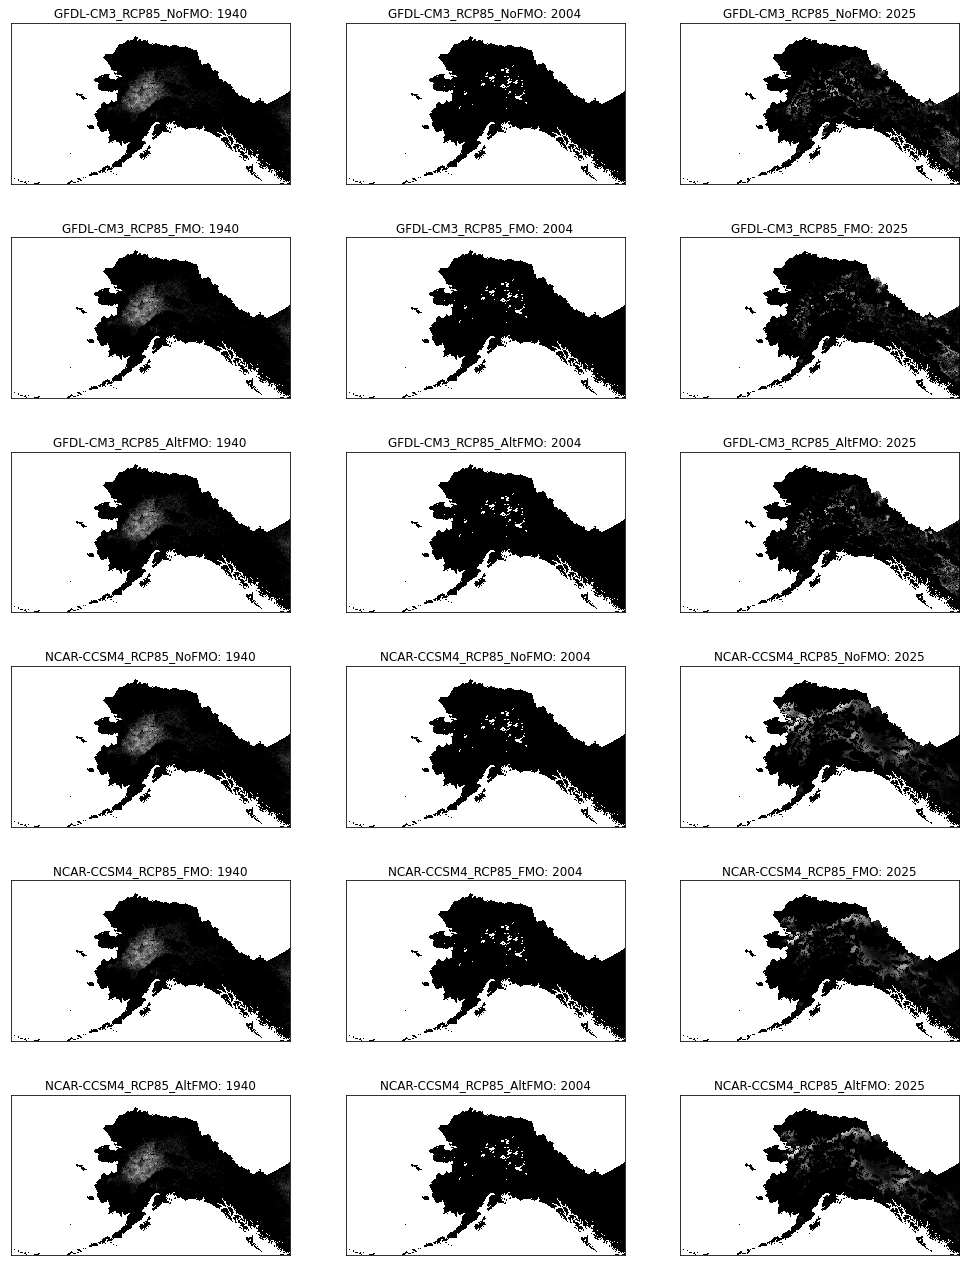

In [51]:
fig, axs = plt.subplots(6, 3, figsize=(17, 23), sharex=True, sharey=True)
fig.patch.set_facecolor("white")
for ax, fp in zip(axs.flatten(), flammability_sample):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    with rasterio.open(fp["tif"]) as src:
        arr = src.read(1).astype(float)
        arr[arr == src.nodata] = np.nan
        ax.imshow(arr, cmap="gray", interpolation="none")
        ax.set_title(fp["title"] + ": " + fp["year"])

Notice how the flammability plots for the 1940 column are identical because all models and FMO scenarios are using the same CRU TS 4.0 inputs up to this point.

The flammability plots for the 2004 column are also the same because they all share the same historical fire inputs up to this point. Also notice that the sploches of flammability in the 2004 plots are pure white, not various shades of gray, because all 200 replicates agree that historical fires took place in these areas.

Finally, notice that there is some variation between the 2025 plots. There is substantial variation between the flammability of the models, but also slight variation between FMO scenarios within the same model. This is what we expect to see.